# 3 Build a custom dataloader

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import sys
sys.path.insert(0, "../..")

from src.data import data_tools
from pathlib import Path
import numpy as np
# NB: you will get a cuda warning if you don't have a GPU available.

The problem with images is that the size grows pretty fast.

In [2]:
image_size = (180, 180, 3)

for i in [1, 10, 100]:
    size = (i, ) + image_size
    X = np.zeros(size)
    size_byte = X.nbytes
    print(f"Size for {i} images: {size_byte / (2**20)} MB")

Size for 1 images: 0.7415771484375 MB
Size for 10 images: 7.415771484375 MB
Size for 100 images: 74.15771484375 MB


Tensorflow has a nice [collection of datasets](https://www.tensorflow.org/datasets) for machine learning tasks. Let's download the 'flower_photos' dataset. We will use that dataset for image classification later on. 

In [3]:
import tensorflow as tf
data_dir = "../../data/raw"
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
image_folder = tf.keras.utils.get_file(
    'flower_photos', 
    origin=dataset_url, 
    untar=True,
    cache_dir=data_dir)

image_folder = Path(image_folder)

Let's  build a datagenerator from scratch; even though there are a lot of libraries (tensorflow, pytorch, trax) that provide datagenerators for images, it is a usefull practice to learn how the inside works. 

Eventually you will encounter a task were you will need to read in data from disk, and it is always usefull if you know how to adapt to a custom case. First step is to list all files in the directory:

In [4]:
paths = data_tools.walk_dir(image_folder)
file = next(paths)
file

PosixPath('/Users/rgrouls/code/deep_learning/data/raw/datasets/flower_photos/roses/16209331331_343c899d38.jpg')

In [45]:
%timeit data_tools.load_image(file, image_size=(180, 180), channels=3)

2.68 ms ± 45.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The stucture that is often used is to have subfolders that indicate a label. Here you see that the photo is inside the `tulips` subfolder, so the class label should be `tulips`

/Users/rgrouls/code/deep_learning/data/raw/datasets/flower_photos/roses/22982871191_ec61e36939_n.jpg


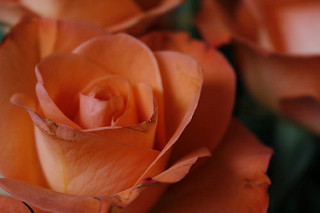

In [30]:
from PIL import Image
file = next(paths)
img = Image.open(file)
print(file)
img

Study the code inside the `src.data.data_tools.py` file to see how this function works.

The `data_tools.iter_valid_paths` function pulls all files, retrieves the classnames by gathering the names of the subfolders, and returns both

In [31]:
from src.data import data_tools

formats = [".png", ".jpg"]
paths, class_names = data_tools.iter_valid_paths(
    path = image_folder, 
    formats=formats
)

In [37]:
next(paths), class_names

(PosixPath('/Users/rgrouls/code/deep_learning/data/raw/datasets/flower_photos/roses/8983268106_dc913d17d8_m.jpg'),
 ['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips'])

And, last, we need the `data_tools.load_image` function.

While there are multiple libraries available to load images (`pyvips`, `PIL`) the functions from `tensorflow` are the fastest for the sequence of tasks:
- load image from disk
- decode into an array of numbers
- resize the image to a fixed size
- cast to `numpy` array

In [40]:
file = next(paths)
img = data_tools.load_image(file, (180, 180), 3)
type(img), img.shape

(numpy.ndarray, (180, 180, 3))

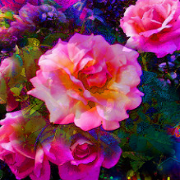

In [41]:
Image.fromarray(img.astype(np.uint8))

With this, we can construct our own data generator, using the design pattern we looked at in lesson 2.

- We gather all the paths to files
- We shuffle the index_list 
- For the range of `batchsize`, we use the `index_list[index]` design pattern to gather a random batch
- label name is extacted from the subfolder name

In [47]:
datagen = data_tools.data_generator(
    batch_size = 32, 
    path = image_folder, 
    image_size = (150, 150),
    channels = 3,
    shuffle = True
)

We can time this, and it is fast enough, considering we have a batchsize of 32; I clocked 2.68ms for a single image, so that would give us about 86ms for just the loading of the 32 images from disk. The additional 20ms for resizing, decoding and casting to numpy for 32 images comes down to about 0.5ms per image.

In [48]:
%timeit next(datagen)

109 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The result:

In [49]:
X, y = next(datagen)
X.shape, y.shape

((32, 150, 150, 3), (32,))